In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
import json
from tqdm import tqdm
import glob
import numpy as np
import cv2
import sys

tqdm.pandas()

In [2]:
# Add the project root to sys.path to import custom modules
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
sys.path.append(project_root)

# Import custom utilities
from src.utils.video_util import get_video_properties, get_frames, calculate_motion
from src.utils.dataset_utils import download_dataset
from src.utils.directory_utils import display_directory_tree

In [3]:
# Đặt đường dẫn dataset
dataset_root = os.path.join(project_root, "data", "ZaloAI_dataset")
dataset_slug = "hlly34/liveness-detection-zalo-2022"

# Gọi hàm download_dataset
if not download_dataset(dataset_slug, dataset_root):
    raise Exception("Failed to download dataset. Please follow the instructions above.")

Dataset already exists locally


In [4]:
# Hiển thị cấu trúc thư mục
print("Cấu trúc thư mục Dataset:")
display_directory_tree(dataset_root, max_depth=4)

Cấu trúc thư mục Dataset:
ZaloAI_dataset/
    private_test/
        private_test/
            videos/
                0.mp4/
                1.mp4/
                10.mp4/
                100.mp4/
                1000.mp4/
                1001.mp4/
                1002.mp4/
                1003.mp4/
                1004.mp4/
                1005.mp4/
                ... (1243 more)
    public_test/
        public/
            videos/
                0.mp4/
                100.mp4/
                1001.mp4/
                1005.mp4/
                1022.mp4/
                1023.mp4/
                1045.mp4/
                1048.mp4/
                1049.mp4/
                1062.mp4/
                ... (340 more)
    public_test_2/
        public_test_2/
            videos/
                0.mp4/
                1.mp4/
                10.mp4/
                100.mp4/
                101.mp4/
                102.mp4/
                103.mp4/
                104.mp4/
                10

In [17]:
# Define dataset paths
train_label_path = dataset_root / "train" / "train" / "label.csv"
train_videos_dir = dataset_root / "train" / "train" / "videos"

# Load training labels
train_labels = pd.read_csv(train_label_path)

# Display first few rows
print("Nhãn Huấn Luyện:")
print(train_labels.head())

# Check for missing values
print("\nGiá trị thiếu:")
print(train_labels.isnull().sum())

# Distribution of liveness_score
print("\nPhân phối liveness_score:")
print(train_labels["liveness_score"].value_counts())

Nhãn Huấn Luyện:
   fname  liveness_score
0  1.mp4               0
1  2.mp4               1
2  3.mp4               1
3  5.mp4               0
4  7.mp4               1

Giá trị thiếu:
fname             0
liveness_score    0
dtype: int64

Phân phối liveness_score:
liveness_score
1    598
0    570
Name: count, dtype: int64


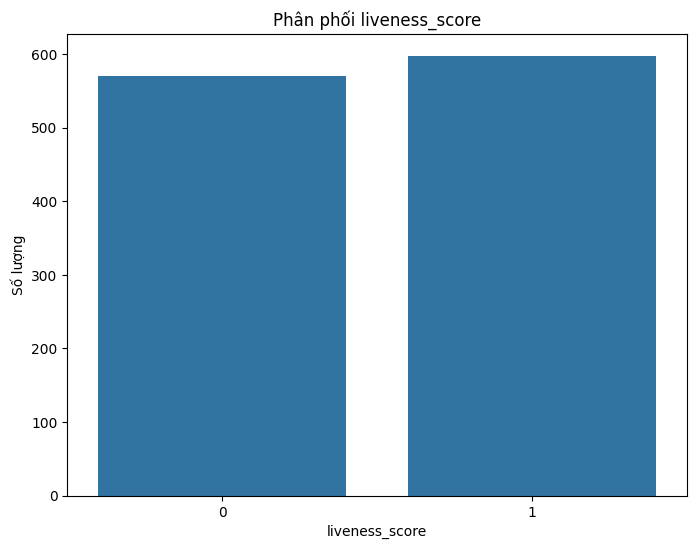

In [ ]:
# Plot the distribution of liveness_score
plt.figure(figsize=(8, 6))
sns.countplot(x="liveness_score", data=train_labels)
plt.title("Phân phối liveness_score")
plt.xlabel("liveness_score")
plt.ylabel("Số lượng")
plt.show()

In [19]:
# Count videos in each dataset directory
def count_videos(directory):
    return len([f for f in os.listdir(directory) if f.endswith(".mp4")])


directories = {
    "private_test": dataset_root / "private_test" / "private_test" / "videos",
    "public_test": dataset_root / "public_test" / "public" / "videos",
    "public_test_2": dataset_root / "public_test_2" / "public_test_2" / "videos",
    "train": dataset_root / "train" / "train" / "videos",
}

video_counts = {name: count_videos(path) for name, path in directories.items()}

print("\nSố lượng video trong mỗi thư mục:")
for name, count in video_counts.items():
    print(f"{name}: {count} video")


Số lượng video trong mỗi thư mục:
private_test: 1253 video
public_test: 350 video
public_test_2: 486 video
train: 1168 video


In [20]:
# Add video path column to train_labels
train_labels["video_path"] = train_labels["fname"].apply(
    lambda x: str(train_videos_dir / x)
)

In [21]:
# Extract video properties
print("\nĐang trích xuất thông tin kỹ thuật của video...")
video_properties = train_labels["video_path"].progress_apply(get_video_properties)
train_data = pd.concat([train_labels, video_properties], axis=1)


Đang trích xuất thông tin kỹ thuật của video...


100%|██████████| 1168/1168 [00:10<00:00, 108.05it/s]



Thống kê về độ phân giải video:
             width       height
count  1168.000000  1168.000000
mean    819.953767  1428.979452
std     349.667323   627.147468
min     240.000000   480.000000
25%     480.000000   852.000000
50%     720.000000  1280.000000
75%    1080.000000  1920.000000
max    2160.000000  3840.000000


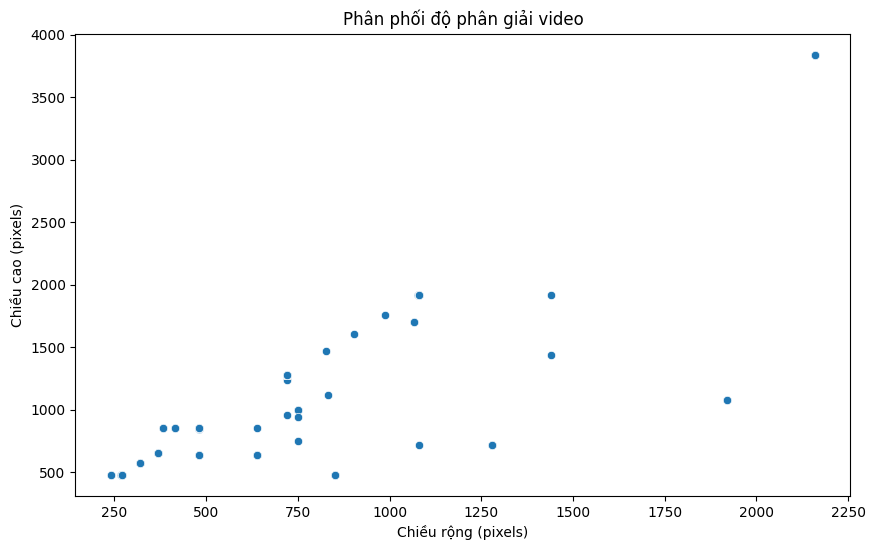

In [ ]:
# Display statistics about video resolution
print("\nThống kê về độ phân giải video:")
print(train_data[["width", "height"]].describe())

# Plot video resolution distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(x="width", y="height", data=train_data)
plt.title("Phân phối độ phân giải video")
plt.xlabel("Chiều rộng (pixels)")
plt.ylabel("Chiều cao (pixels)")
plt.show()


Thống kê về FPS của video:
count    1168.000000
mean       30.345497
std         2.227057
min        14.170000
25%        30.000000
50%        30.000000
75%        32.000000
max        59.000000
Name: fps, dtype: float64


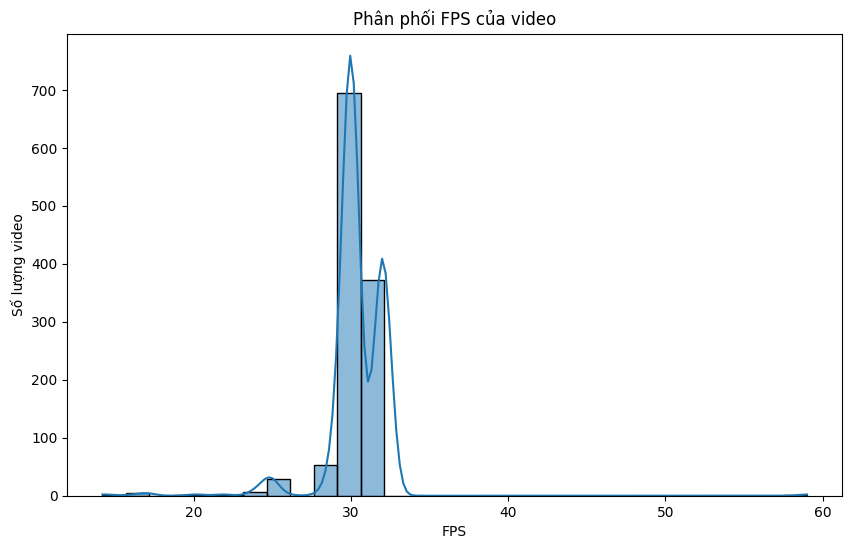

In [ ]:
# Analyze FPS of videos
print("\nThống kê về FPS của video:")
print(train_data["fps"].describe())

plt.figure(figsize=(10, 6))
sns.histplot(train_data["fps"].dropna(), bins=30, kde=True)
plt.title("Phân phối FPS của video")
plt.xlabel("FPS")
plt.ylabel("Số lượng video")
plt.show()


Thống kê về số khung hình của video:
count    1168.000000
mean      151.342466
std        15.030988
min        16.000000
25%       150.000000
50%       152.000000
75%       160.000000
max       295.000000
Name: frame_count, dtype: float64


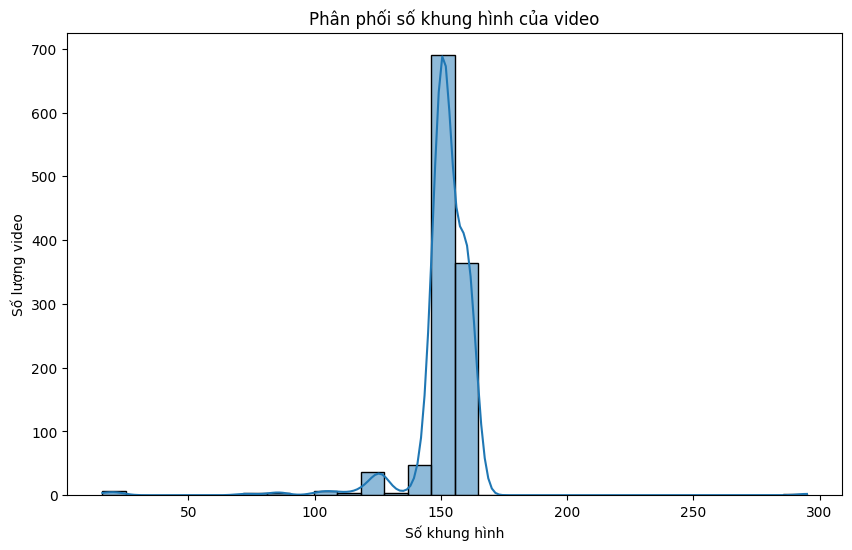

In [ ]:
# Analyze frame count of videos
print("\nThống kê về số khung hình của video:")
print(train_data["frame_count"].describe())

plt.figure(figsize=(10, 6))
sns.histplot(train_data["frame_count"].dropna(), bins=30, kde=True)
plt.title("Phân phối số khung hình của video")
plt.xlabel("Số khung hình")
plt.ylabel("Số lượng video")
plt.show()

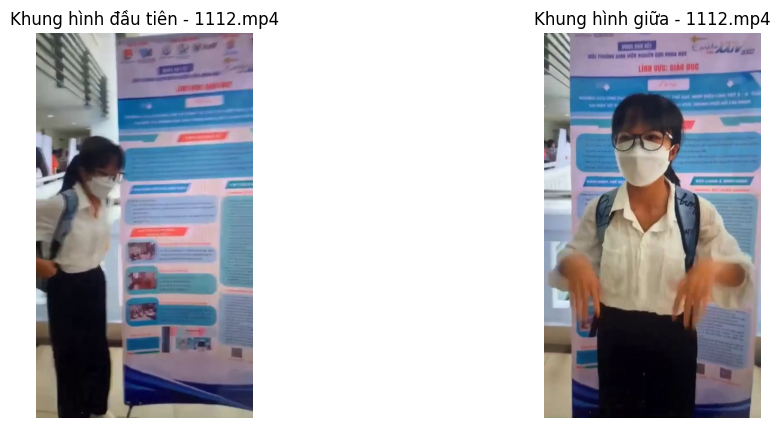

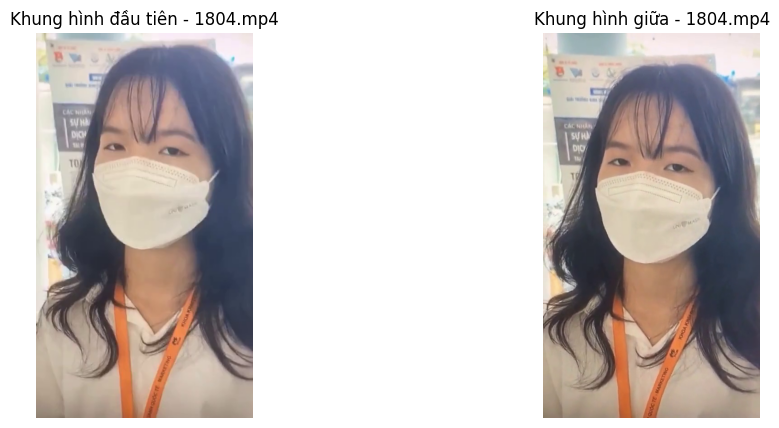

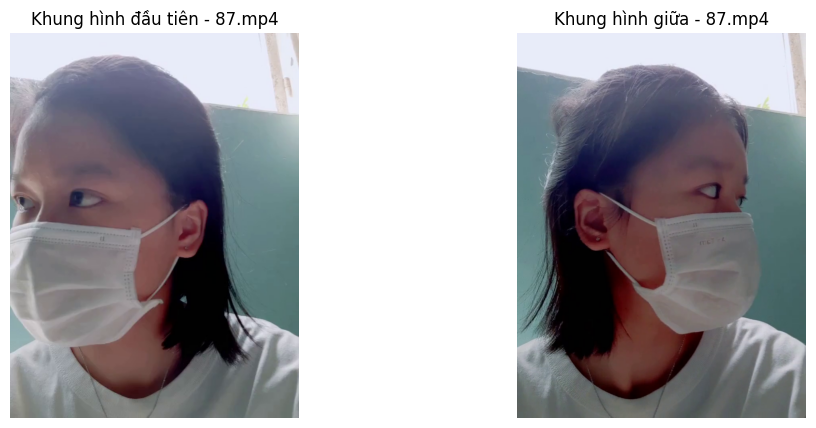

In [ ]:
# Display sample frames from videos
sample_videos = train_data.sample(3, random_state=42)
for index, row in sample_videos.iterrows():
    frame1, frame2 = get_frames(row["video_path"])
    if frame1 is not None and frame2 is not None:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
        plt.title(f"Khung hình đầu tiên - {row['fname']}")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
        plt.title(f"Khung hình giữa - {row['fname']}")
        plt.axis("off")
        plt.show()
    else:
        print(f"Không thể đọc video {row['fname']}")

In [26]:
# Calculate motion for a sample of videos
print("\nĐang tính toán mức độ chuyển động cho các video mẫu...")
sample_indices = train_data.sample(50, random_state=42).index
train_data.loc[sample_indices, "motion"] = train_data.loc[
    sample_indices, "video_path"
].progress_apply(calculate_motion)


Đang tính toán mức độ chuyển động cho các video mẫu...


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]



Thống kê về mức độ chuyển động:
count    50.000000
mean      2.960556
std       2.346607
min       0.230418
25%       1.395768
50%       2.466145
75%       4.035482
max      13.560238
Name: motion, dtype: float64


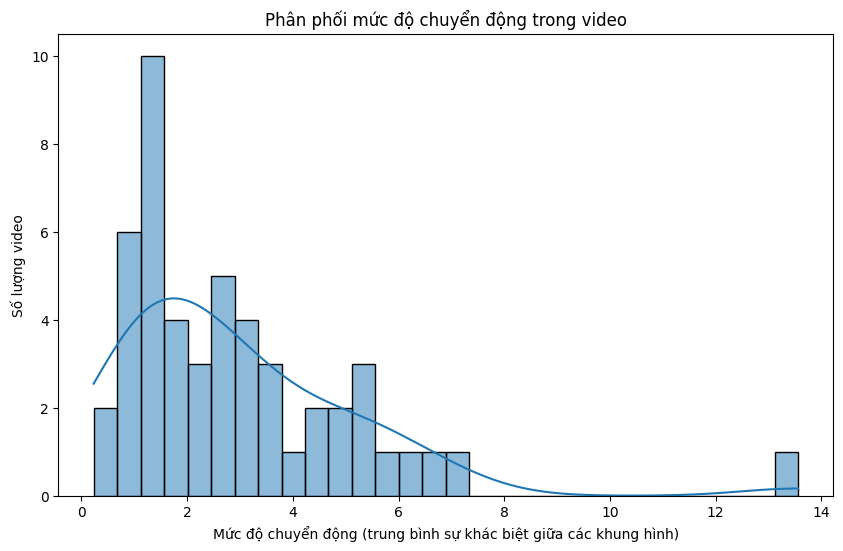

In [ ]:
# Motion statistics
print("\nThống kê về mức độ chuyển động:")
print(train_data["motion"].describe())

# Plot motion distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data["motion"].dropna(), bins=30, kde=True)
plt.title("Phân phối mức độ chuyển động trong video")
plt.xlabel("Mức độ chuyển động (trung bình sự khác biệt giữa các khung hình)")
plt.ylabel("Số lượng video")
plt.show()

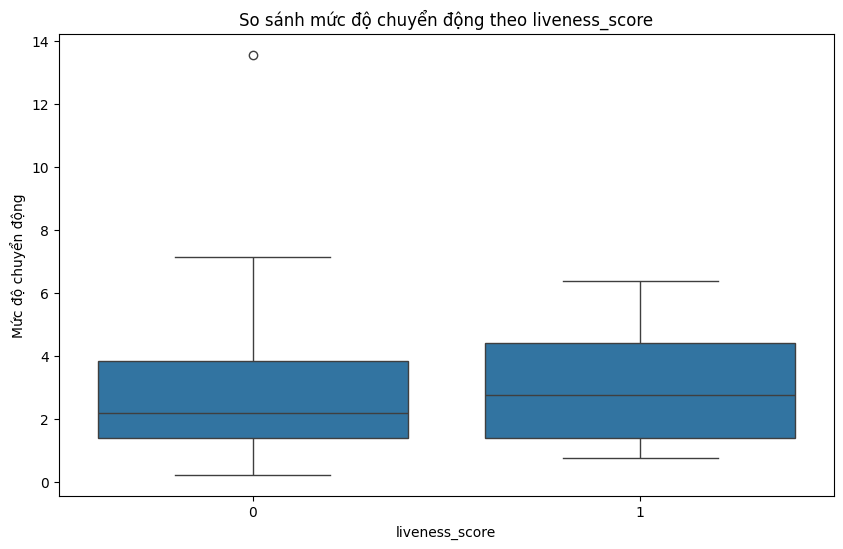

In [28]:
# Compare motion between live and spoof videos
plt.figure(figsize=(10, 6))
sns.boxplot(x="liveness_score", y="motion", data=train_data.dropna(subset=["motion"]))
plt.title("So sánh mức độ chuyển động theo liveness_score")
plt.xlabel("liveness_score")
plt.ylabel("Mức độ chuyển động")
plt.show()


Thống kê về thời lượng video:
count    1168.000000
mean        4.989171
std         0.342714
min         0.500000
25%         5.000000
50%         5.000000
75%         5.066667
max         5.098980
Name: duration, dtype: float64


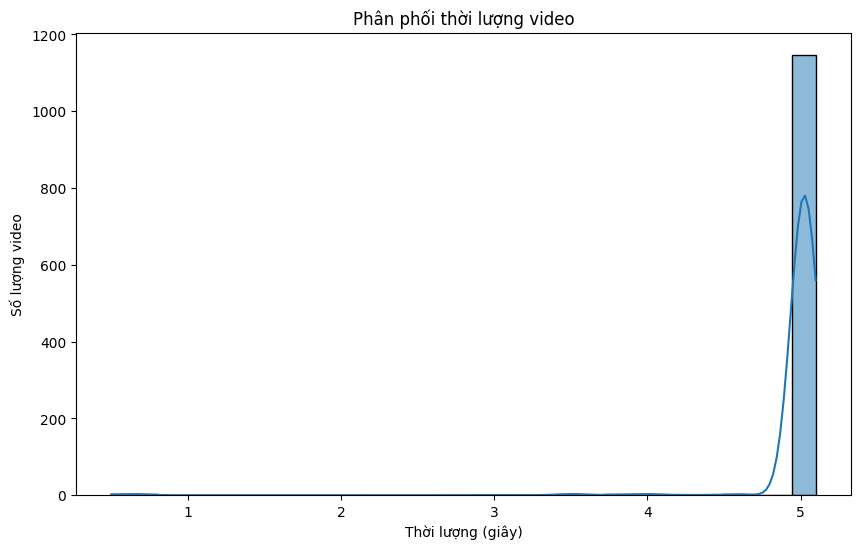

In [29]:
# Additional EDA: Analyze duration of videos
print("\nThống kê về thời lượng video:")
print(train_data["duration"].describe())

plt.figure(figsize=(10, 6))
sns.histplot(train_data["duration"].dropna(), bins=30, kde=True)
plt.title("Phân phối thời lượng video")
plt.xlabel("Thời lượng (giây)")
plt.ylabel("Số lượng video")
plt.show()


Ma trận tương quan:
                frame_count       fps  duration    motion  liveness_score
frame_count        1.000000  0.692469  0.668051 -0.004687       -0.134384
fps                0.692469  1.000000 -0.073970 -0.031509       -0.173619
duration           0.668051 -0.073970  1.000000  0.059117       -0.004629
motion            -0.004687 -0.031509  0.059117  1.000000       -0.004547
liveness_score    -0.134384 -0.173619 -0.004629 -0.004547        1.000000


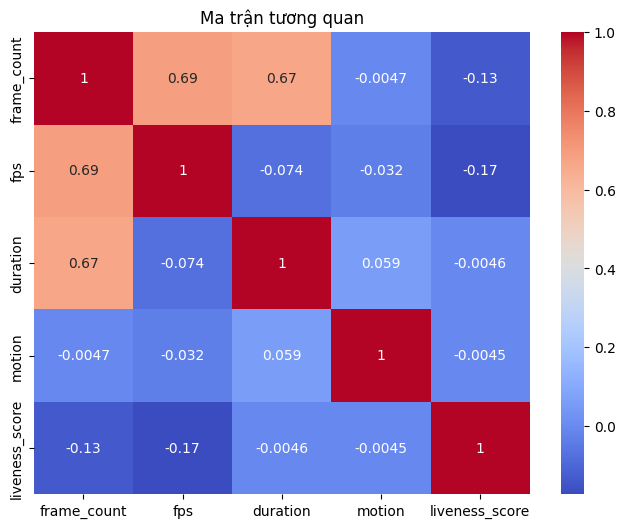

In [30]:
# Correlation analysis
print("\nMa trận tương quan:")
corr_matrix = train_data[
    ["frame_count", "fps", "duration", "motion", "liveness_score"]
].corr()
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Ma trận tương quan")
plt.show()

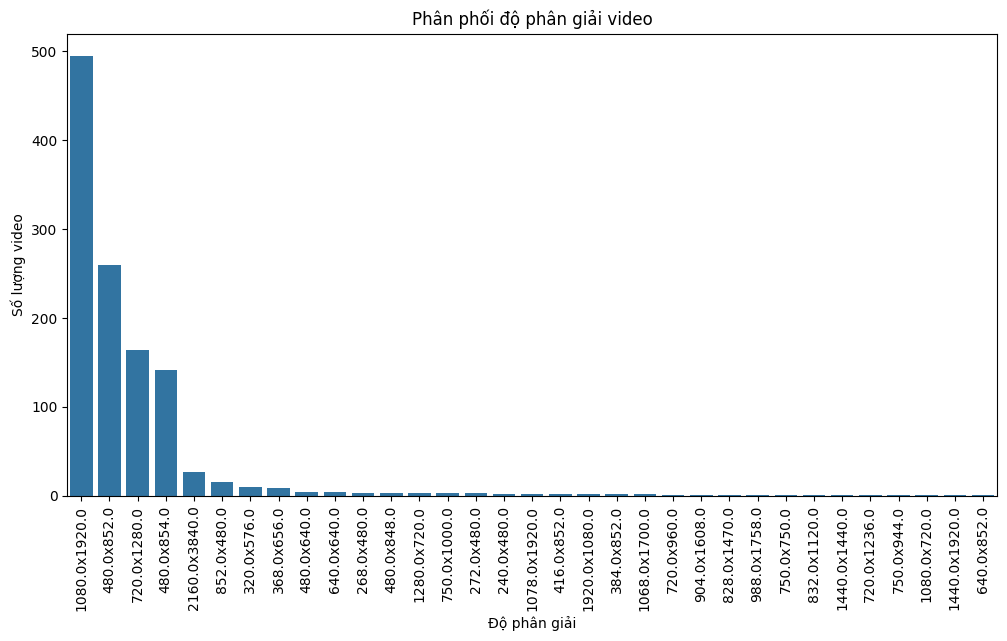

In [31]:
# Distribution of video resolutions
train_data["resolution"] = (
    train_data["width"].astype(str) + "x" + train_data["height"].astype(str)
)
resolution_counts = train_data["resolution"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=resolution_counts.index, y=resolution_counts.values)
plt.title("Phân phối độ phân giải video")
plt.xlabel("Độ phân giải")
plt.ylabel("Số lượng video")
plt.xticks(rotation=90)
plt.show()

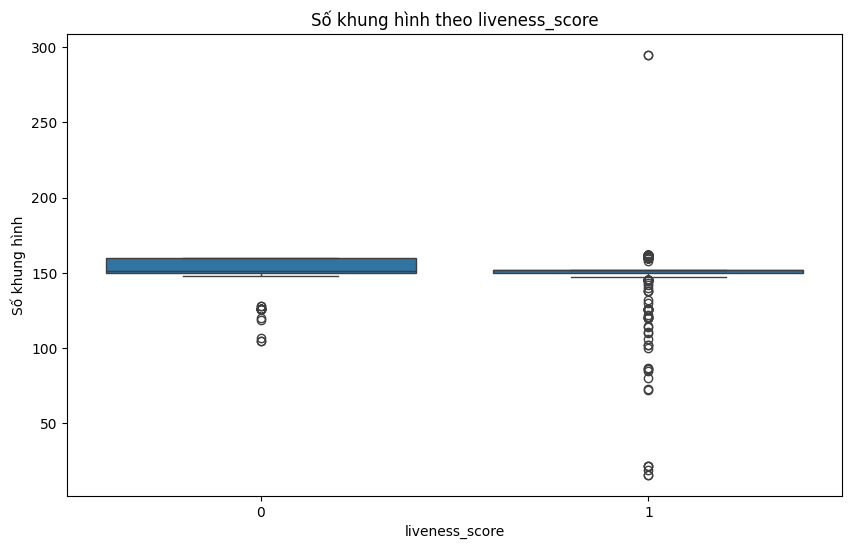

In [32]:
# Analyze relationship between frame count and liveness_score
plt.figure(figsize=(10, 6))
sns.boxplot(x="liveness_score", y="frame_count", data=train_data)
plt.title("Số khung hình theo liveness_score")
plt.xlabel("liveness_score")
plt.ylabel("Số khung hình")
plt.show()

In [33]:
# Analyze average pixel intensity differences between live and spoof videos
def calculate_avg_pixel_intensity(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    intensities = []
    for _ in range(min(frame_count, 30)):  # Limit to 30 frames for performance
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        intensity = np.mean(gray)
        intensities.append(intensity)
    cap.release()
    if intensities:
        return np.mean(intensities)
    else:
        return None


print("\nĐang tính toán cường độ pixel trung bình cho các video mẫu...")
train_data.loc[sample_indices, "avg_intensity"] = train_data.loc[
    sample_indices, "video_path"
].progress_apply(calculate_avg_pixel_intensity)


Đang tính toán cường độ pixel trung bình cho các video mẫu...


100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


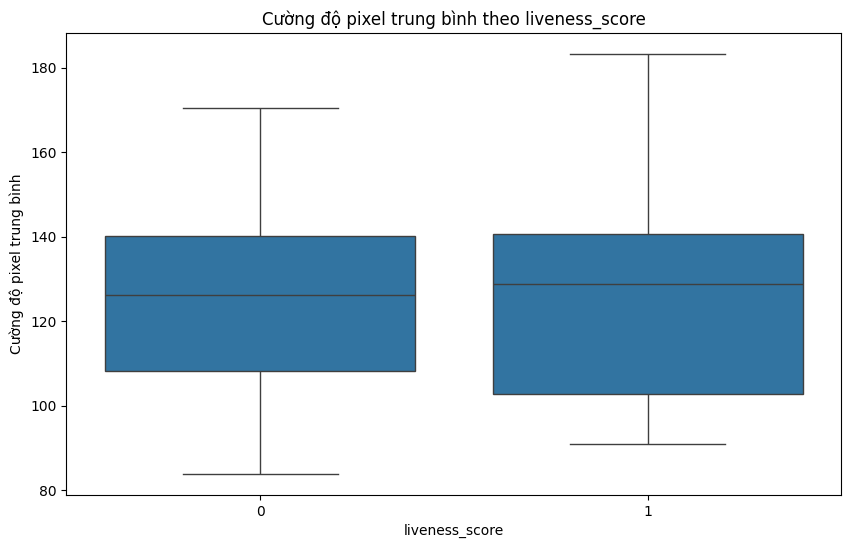

In [34]:
# Compare average pixel intensity between live and spoof videos
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="liveness_score",
    y="avg_intensity",
    data=train_data.dropna(subset=["avg_intensity"]),
)
plt.title("Cường độ pixel trung bình theo liveness_score")
plt.xlabel("liveness_score")
plt.ylabel("Cường độ pixel trung bình")
plt.show()